In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.metrics import mean_squared_error, log_loss, r2_score
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier
from GBDT.GradientBoostDecisionTree import GBDTClassifier
%matplotlib inline

In [2]:
data = pd.read_csv("./titanic/train.csv").dropna()
data

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S
10,11,1,3,"Sandstrom, Miss. Marguerite Rut",female,4.0,1,1,PP 9549,16.7000,G6,S
11,12,1,1,"Bonnell, Miss. Elizabeth",female,58.0,0,0,113783,26.5500,C103,S
...,...,...,...,...,...,...,...,...,...,...,...,...
871,872,1,1,"Beckwith, Mrs. Richard Leonard (Sallie Monypeny)",female,47.0,1,1,11751,52.5542,D35,S
872,873,0,1,"Carlsson, Mr. Frans Olof",male,33.0,0,0,695,5.0000,B51 B53 B55,S
879,880,1,1,"Potter, Mrs. Thomas Jr (Lily Alexenia Wilson)",female,56.0,0,1,11767,83.1583,C50,C
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S


In [3]:
x_columns = ['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare']
x_catagory = ['Sex', 'Pclass']
data_x = pd.get_dummies(data[x_columns], columns=x_catagory, drop_first=True)
data_y = data['Survived']

train_x, test_x, train_y, test_y = train_test_split(data_x, data_y, test_size=0.5, random_state=1)
(train_x, train_y)

(       Age  SibSp  Parch      Fare  Sex_male  Pclass_2  Pclass_3
 377  27.00      0      2  211.5000         1         0         0
 331  45.50      0      0   28.5000         1         0         0
 305   0.92      1      2  151.5500         1         0         0
 520  30.00      0      0   93.5000         0         0         0
 449  52.00      0      0   30.5000         1         0         0
 ..     ...    ...    ...       ...       ...       ...       ...
 647  56.00      0      0   35.5000         1         0         0
 679  36.00      0      1  512.3292         1         0         0
 345  24.00      0      0   13.0000         0         1         0
 690  31.00      1      0   57.0000         1         0         0
 218  32.00      0      0   76.2917         0         0         0
 
 [91 rows x 7 columns], 377    0
 331    0
 305    1
 520    1
 449    1
       ..
 647    1
 679    1
 345    1
 690    1
 218    1
 Name: Survived, Length: 91, dtype: int64)

## My GBDT

In [4]:
Gbdt = GBDTClassifier(2000, 0.5, 'deviance', tree_params={'criterion': 'mse', 'max_depth': 5}, subsample=0.8, tol=0.001)
Gbdt.fit(train_x, train_y)

early stopping in round 350, best round is 330, M = 350


GBDTClassifier(learning_rate=0.5, loss='deviance', n_estimators=350,
               n_iter_no_change=2, random_state=None, subsample=0.8,
               tol=0.00025, tree_params={'criterion': 'mse', 'max_depth': 5})

In [5]:
r2_score(train_y, Gbdt.predict(train_x))

1.0

In [6]:
r2_score(test_y, Gbdt.predict(test_x))

-0.23655913978494647

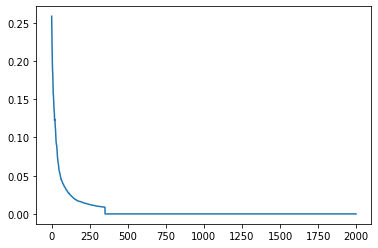

In [7]:
plt.plot(range(len(Gbdt.train_score_)), Gbdt.train_score_)

In [8]:
Gbdt.feature_importances_

array([0.42684156, 0.02984437, 0.04158504, 0.37110242, 0.12253617,
       0.00961188, 0.00133569])

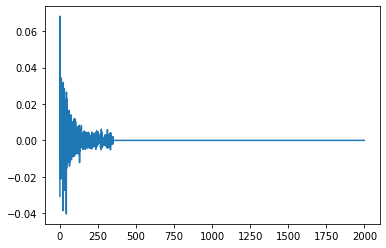

In [9]:
plt.plot(range(len(Gbdt.oob_improvement_)), Gbdt.oob_improvement_)

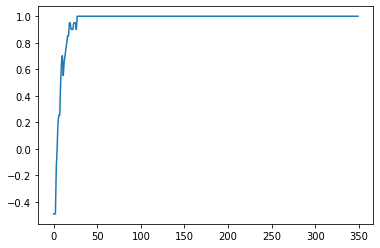

In [10]:
scores = [r2_score(train_y, pred) for pred in Gbdt.staged_predict(train_x)]
plt.plot(np.arange(len(scores)), scores)

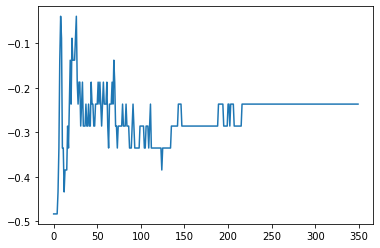

In [11]:
scores = [r2_score(test_y, pred) for pred in Gbdt.staged_predict(test_x)]
plt.plot(np.arange(len(scores)), scores)

 ## Sklearn GBDT

In [12]:
gbr = GradientBoostingClassifier(criterion='mse', loss='deviance', n_estimators=100, learning_rate=0.1, max_depth=3, subsample=0.7)
gbr.fit(train_x, train_y)

GradientBoostingClassifier(criterion='mse', init=None, learning_rate=0.1,
                           loss='deviance', max_depth=3, max_features=None,
                           max_leaf_nodes=None, min_impurity_decrease=0.0,
                           min_impurity_split=None, min_samples_leaf=1,
                           min_samples_split=2, min_weight_fraction_leaf=0.0,
                           n_estimators=100, n_iter_no_change=None,
                           presort='auto', random_state=None, subsample=0.7,
                           tol=0.0001, validation_fraction=0.1, verbose=0,
                           warm_start=False)

In [13]:
r2_score(train_y, gbr.predict(train_x))

1.0

In [14]:
r2_score(test_y, gbr.predict(test_x))

-0.13763440860215082

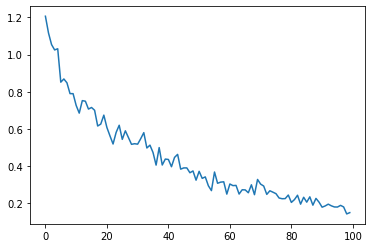

In [15]:
plt.plot(range(len(gbr.train_score_)), gbr.train_score_)

In [16]:
gbr.feature_importances_

array([3.35091798e-01, 2.05293031e-02, 2.44716431e-02, 3.53922833e-01,
       2.63985295e-01, 1.88389030e-03, 1.15238089e-04])

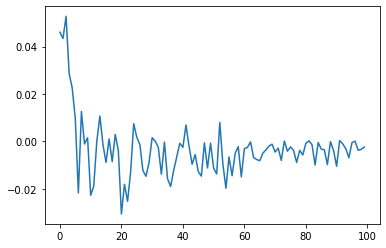

In [17]:
plt.plot(range(len(gbr.oob_improvement_)), gbr.oob_improvement_)

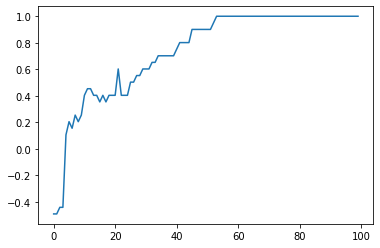

In [18]:
scores = [r2_score(train_y, pred) for pred in gbr.staged_predict(train_x)]
plt.plot(np.arange(len(scores)), scores)

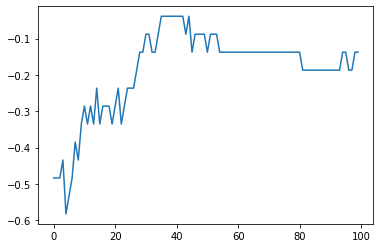

In [19]:
scores = [r2_score(test_y, pred) for pred in gbr.staged_predict(test_x)]
plt.plot(np.arange(len(scores)), scores)